### Objective

To predict cutomer sentiments from customer feedback data form twitter 

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import ftfy
import string
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,plot_roc_curve
from sklearn.model_selection import cross_val_score

import scikitplot as skplt

import xgboost as xgb

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Excel observations:


Based on excel observation for preprocessing, we need to handle below cases:
* words starting with @
* links
* punctuations
* textencoding
* text in ()

Also there are no null values for any column

In [2]:
airline_df=pd.read_csv('Usecase3_Dataset.csv')

In [3]:
airline_df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


## Data Analysis

In [4]:
print("Total of {} Airline's data present with us".format(airline_df.airline.nunique()))

Total of 6 Airline's data present with us


In [5]:
#check number of twwets belonging to each airline
airline_df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [6]:
#check for class imbalance on overall data
#As we can see from the below analysis, there is huge class imbalance between target classes. 
#But the good thing here is, the class of interest i.e 'negative' sentiment class has more number of samples compared to other classes.
# This can help our model to do better predictions for negative sentiment
airline_df.airline_sentiment.value_counts()


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

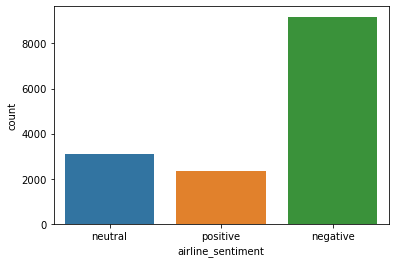

In [7]:
sns.countplot(airline_df.airline_sentiment)

In [8]:
# Check for number of positive and negative sentiments for various airlines

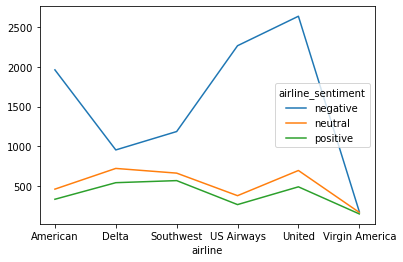

In [9]:

airline_df.groupby(['airline','airline_sentiment'])['text'].count().unstack().plot()

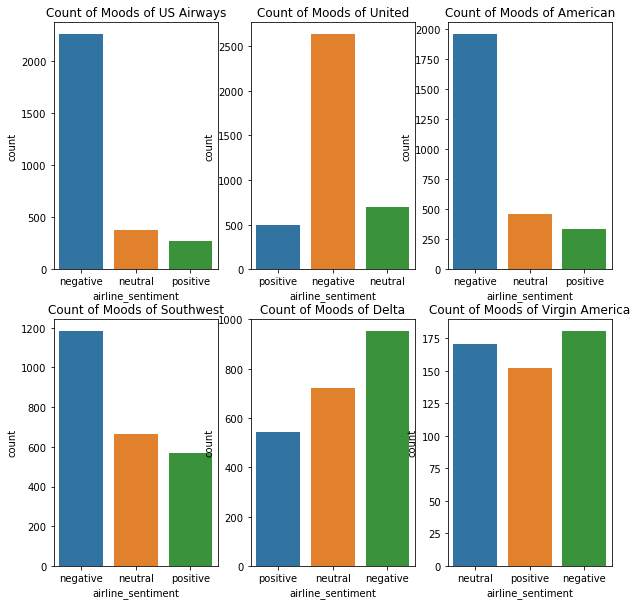

In [10]:
plt.figure(1,figsize=(10,10))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
for i in airlines:
    indices=airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_value=airline_df[airline_df['airline']==i]
    Index = [1,2,3]
    sns.countplot(new_value['airline_sentiment'])
    plt.title('Count of Moods of '+i)

In [11]:
# Visualize words present in each class of sentiment

In [12]:
#let's first take copy of our dataframe
df=airline_df.copy(deep=True)

In [13]:
df.shape

(14640, 3)

In [14]:
#drop duplicate records if any
df.drop_duplicates(inplace=True)

In [15]:
# as we can see there were around approx 200 duplicate tweets
df.shape

(14452, 3)

In [ ]:
# In tweets, hashtags can point to sentiment of tweets, so we will not remove hashtags just clean '#' from tweet.

In [16]:
#clean tweets
def clean_text(text_val):
    text = text_val
    text = text.lower()
    text=text.replace('“','').replace('”','')
    text=' '.join([word for word in text.split() if not word.startswith('@')]) #remove words starting with @
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text= re.sub('https?://[A-Za-z0-9./]+','',text)
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text)
    text=''.join([ele for ele in text if ele not in string.punctuation])
    return text

In [18]:
# Generate wordcloud to visualize words which contributes to  negative sentiments so as to get an idea on aspects which airlines can work on

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


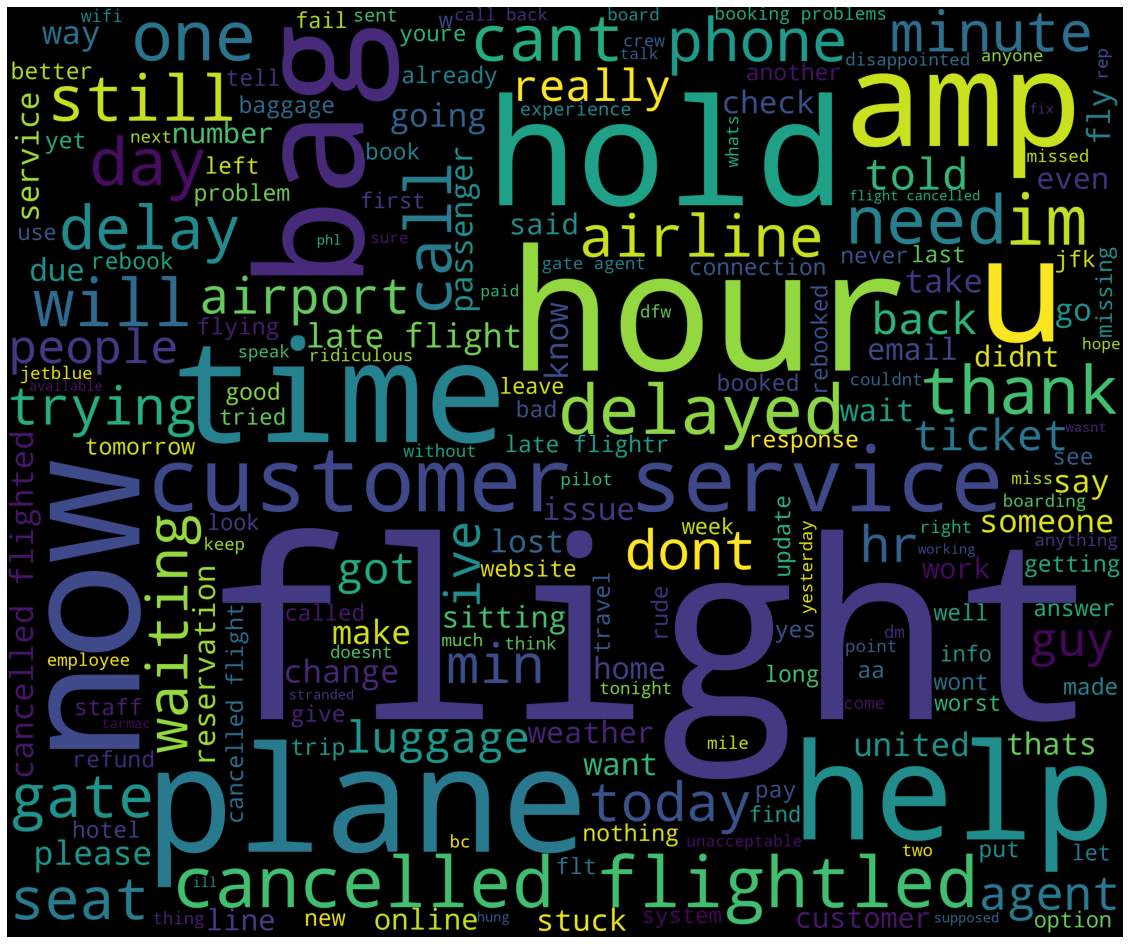

In [19]:
negative_df=df[df['airline_sentiment']=='negative']
negative_df['text']=negative_df.text.apply(lambda x : clean_text(x))
words = ' '.join(negative_df['text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


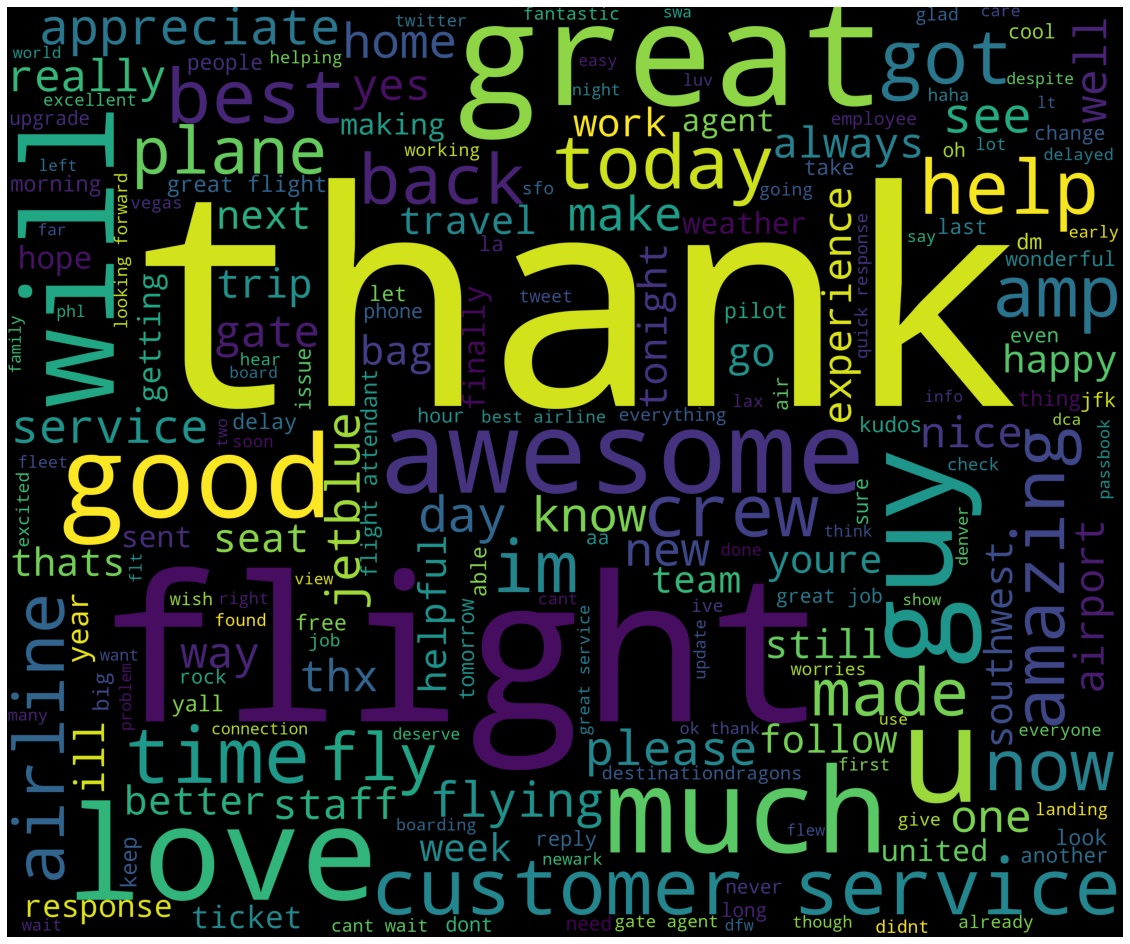

In [20]:

#Generate wordcloud to visualize words which contributes to  positive sentiments
positive_df=df[df['airline_sentiment']=='positive']
positive_df['text']=positive_df.text.apply(lambda x : clean_text(x))
words = ' '.join(positive_df['text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(20,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



In [17]:
#processing of text
lemmatizer = WordNetLemmatizer()
def preprocess_text(text_val):
    text=clean_text(text_val)
    text=' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)  if len(word)>2  and word not in stop_words])
    return text

In [18]:
df['text']=df.text.apply(lambda x: preprocess_text(x))

In [19]:
#As machine learning models doesn't understand textual data, we have to convert the sentiment categories to numeric value
#We will map positive to 2, neutral to 1 and negative to 0
df['airline_sentiment']=df.airline_sentiment.replace({'positive':2,'neutral':1,'negative':0})

In [20]:
df.head()

,airline_sentiment,airline,text
0,1,Virgin America,said
1,2,Virgin America,plus youve added commercial experience tacky
2,1,Virgin America,didnt today must mean need take another trip
3,0,Virgin America,really aggressive blast obnoxious entertainmen...
4,0,Virgin America,really big bad thing


In [21]:
#Let's create a numeric representation of text
# Tfidf vectorizer helps us to create a numeric representation of text. Parameters to tune are ngram range and min_df,max_df

vectorizer = TfidfVectorizer(ngram_range=(1,3),min_df=10)
X= vectorizer.fit_transform(df.text)


In [22]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
#Split data into train and test set
X_train,X_test,y_train,y_test = train_test_split(X.toarray(),df['airline_sentiment'],test_size=0.2, random_state=42)


In [24]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(11561, 2238) (11561,)
(2891, 2238) (2891,)


# Model Building

### Logistic Regression

In [26]:
lr=LogisticRegression()
param_grid = {
              "C": [0.001,0.01,0.1,0.5,0.15,1,10,],
              "solver": ['newton-cg','lbfgs','liblinear','sag','saga'],
              }

CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv= 5)
CV_lr.fit(X_train, y_train)


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.15, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [29]:
print("Best Parameters:")
print(CV_lr.best_params_)
print(CV_lr.best_score_)


Best Parameters:
{'C': 1, 'solver': 'lbfgs'}
0.7768356453743472


In [31]:
lr_predictions=CV_lr.predict(X_test)


In [32]:
#We can see that we got a f1-score of 86 for negative class using logistic regression
print(confusion_matrix(y_test,lr_predictions))
print(classification_report(y_test,lr_predictions))


[[1674   85   41]
 [ 282  296   33]
 [ 147   77  256]]
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1800
           1       0.65      0.48      0.55       611
           2       0.78      0.53      0.63       480

    accuracy                           0.77      2891
   macro avg       0.74      0.65      0.68      2891
weighted avg       0.76      0.77      0.76      2891



In [81]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value=precision_recall_fscore_support(y_test, lr_predictions, average=None,labels=[0,1,2])

recall_for_class_0_logistic_regression=round(metrics_value[1][0],2)
f1score_for_class_0_logistic_regression=round(metrics_value[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


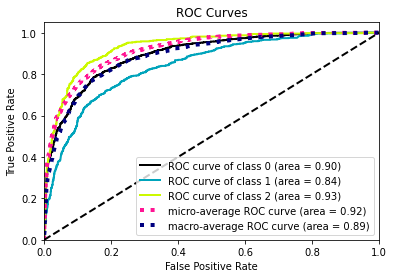

In [66]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, CV_lr.predict_proba(X_test))


### SVC

In [67]:
svc_model=SVC(probability=True,kernel='poly')


'''
param_grid = {
            "kernel":['linear','poly','rbf','sigmoid'],
             'gamma' :[0.001, 0.01, 0.1, 1],
              "C": [0.001,0.01,0.1,0.5,0.15,1,10]
              }

CV_svc = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv= 5)
CV_svc.fit(X_train, y_train)
'''

'\nparam_grid = {\n            "kernel":[\'linear\',\'poly\',\'rbf\',\'sigmoid\'],\n             \'gamma\' :[0.001, 0.01, 0.1, 1],\n              "C": [0.001,0.01,0.1,0.5,0.15,1,10]\n              }\n\nCV_svc = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv= 5)\nCV_svc.fit(X_train, y_train)\n'

In [68]:
svc_model.fit(X_train,y_train)

SVC(kernel='poly', probability=True)

In [69]:
predictions_svc=svc_model.predict(X_test)

In [71]:
#print confusion matrix and classification report
print(confusion_matrix(y_test,predictions_svc))

print(classification_report(y_test,predictions_svc))


[[1772   19    9]
 [ 465  129   17]
 [ 332   22  126]]
              precision    recall  f1-score   support

           0       0.69      0.98      0.81      1800
           1       0.76      0.21      0.33       611
           2       0.83      0.26      0.40       480

    accuracy                           0.70      2891
   macro avg       0.76      0.49      0.51      2891
weighted avg       0.73      0.70      0.64      2891



In [82]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_svc=precision_recall_fscore_support(y_test, predictions_svc, average=None,labels=[0,1,2])

recall_for_class_0_svc=round(metrics_value_svc[1][0],2)
f1score_for_class_0_svc=round(metrics_value_svc[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


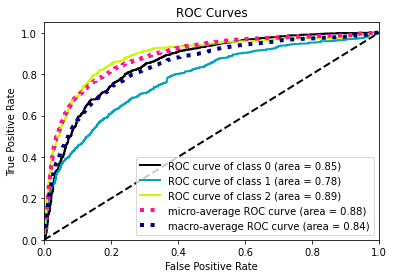

In [73]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, svc_model.predict_proba(X_test))


In [74]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB


### MultinomialNB

In [127]:
#fit model
mnb=MultinomialNB(alpha=0.01)
mnb.fit(X_train,y_train)
predictions_mnb=mnb.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,predictions_mnb))

print(classification_report(y_test,predictions_mnb))


[[1699   68   33]
 [ 357  214   40]
 [ 199   57  224]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1800
           1       0.63      0.35      0.45       611
           2       0.75      0.47      0.58       480

    accuracy                           0.74      2891
   macro avg       0.71      0.59      0.62      2891
weighted avg       0.73      0.74      0.71      2891



In [128]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_mnb=precision_recall_fscore_support(y_test, predictions_mnb, average=None,labels=[0,1,2])

recall_for_class_0_mnb=round(metrics_value_mnb[1][0],2)
f1score_for_class_0_mnb=round(metrics_value_mnb[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


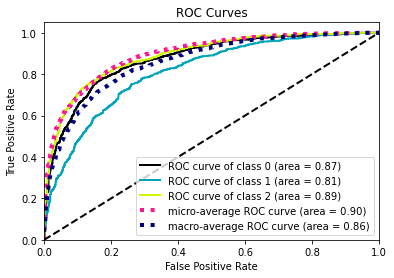

In [86]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, mnb.predict_proba(X_test))


### DecisionTreeClassifier

In [88]:
dtree=DecisionTreeClassifier(random_state=42)
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10, 20, 40],
              "max_depth": range(2,30),
              "min_samples_leaf": range(2,40),
              "max_leaf_nodes": range(2,20),
              }

CV_dtree = RandomizedSearchCV(estimator=dtree, param_distributions=param_grid, cv= 6)
CV_dtree.fit(X_train, y_train)

print("Best Parameters:")
print(CV_dtree.best_params_)
print(CV_dtree.best_score_)


Best Parameters:
{'min_samples_split': 40, 'min_samples_leaf': 17, 'max_leaf_nodes': 16, 'max_depth': 16, 'criterion': 'gini'}
0.6934525910513961


In [89]:
final_dtree_model=DecisionTreeClassifier(min_samples_split= 40, min_samples_leaf=17, max_leaf_nodes= 16, max_depth=16,criterion='entropy')
final_dtree_model.fit(X_train,y_train)
pred_dtree=final_dtree_model.predict(X_test)


In [90]:
#print confusion matrix and classification report
print(confusion_matrix(y_test,pred_dtree))

print(classification_report(y_test,pred_dtree))


[[1727    7   66]
 [ 549   13   49]
 [ 245    5  230]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      1800
           1       0.52      0.02      0.04       611
           2       0.67      0.48      0.56       480

    accuracy                           0.68      2891
   macro avg       0.62      0.49      0.47      2891
weighted avg       0.65      0.68      0.60      2891



In [99]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_dtree=precision_recall_fscore_support(y_test, pred_dtree, average=None,labels=[0,1,2])

recall_for_class_0_dtree=round(metrics_value_dtree[1][0],2)
f1score_for_class_0_dtree=round(metrics_value_dtree[2][0],2)

In [100]:
f1score_for_class_0_dtree

0.8

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


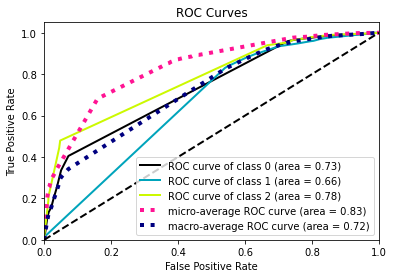

In [94]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, final_dtree_model.predict_proba(X_test))


### RandomForestClassifier

In [95]:
RF_model=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,30,40,50,100,125,150,175,200,225,250,275],
    'max_depth' : range(2,30),
    'criterion':["gini","entropy"],
    "min_samples_leaf": range(1,20),
    "max_leaf_nodes": range(2,20),
    'max_features':["auto", "sqrt", "log2"]
}

CV_rfc = RandomizedSearchCV(estimator=RF_model, param_distributions=param_grid, cv= 6,)
CV_rfc.fit(X_train, y_train)

print("Best Parameters:")
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)


Best Parameters:
{'n_estimators': 30, 'min_samples_leaf': 14, 'max_leaf_nodes': 18, 'max_features': 'sqrt', 'max_depth': 26, 'criterion': 'entropy'}
0.6444081868073934


In [96]:
rc_predictions=CV_rfc.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,rc_predictions))

print(classification_report(y_test,rc_predictions))



[[1796    3    1]
 [ 600   11    0]
 [ 447    3   30]]
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      1800
           1       0.65      0.02      0.04       611
           2       0.97      0.06      0.12       480

    accuracy                           0.64      2891
   macro avg       0.75      0.36      0.31      2891
weighted avg       0.69      0.64      0.51      2891



In [101]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_rf=precision_recall_fscore_support(y_test, rc_predictions, average=None,labels=[0,1,2])

recall_for_class_0_rf=round(metrics_value_rf[1][0],2)
f1score_for_class_0_rf=round(metrics_value_rf[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


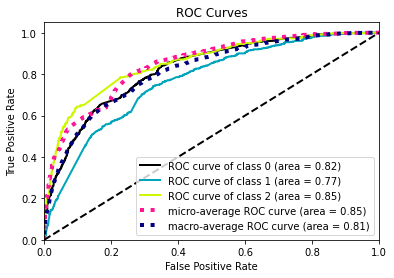

In [102]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, CV_rfc.predict_proba(X_test))

### GradientBoostingClassifier

In [104]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boosting=GradientBoostingClassifier(n_estimators=imators=imators=ilearning_rate=ning_rate=ning_rate=rs=imators=imators=imators=imators=mators=100,max_depth=15,learning_rate=0.01,random_state=42)
'''
param_grid = { 
    'learning_rate':[0.15,0.1,0.05,0.01,0.001],
    'n_estimators':[20,30,40,50,75,100,125,150,175,157,200,225,250,275,300,325,350],
    'max_depth' : range(2,20),
    "max_leaf_nodes": range(2,20),
    'min_samples_split':range(2,15),
    'criterion':['friedman_mse','mse', 'mae']
    
}

CV_gdb = RandomizedSearchCV(estimator=gradient_boosting,param_distributions=param_grid, cv= 6)
CV_gdb.fit(X_train, y_train)

print("Best Parameters:")
print(CV_gdb.best_params_)
print(CV_gdb.best_score_)
'''

'\nparam_grid = { \n    \'learning_rate\':[0.15,0.1,0.05,0.01,0.001],\n    \'n_estimators\':[20,30,40,50,75,100,125,150,175,157,200,225,250,275,300,325,350],\n    \'max_depth\' : range(2,20),\n    "max_leaf_nodes": range(2,20),\n    \'min_samples_split\':range(2,15),\n    \'criterion\':[\'friedman_mse\',\'mse\', \'mae\']\n    \n}\n\nCV_gdb = RandomizedSearchCV(estimator=gradient_boosting,param_distributions=param_grid, cv= 6)\nCV_gdb.fit(X_train, y_train)\n\nprint("Best Parameters:")\nprint(CV_gdb.best_params_)\nprint(CV_gdb.best_score_)\n'

In [105]:
gradient_boosting.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=15, random_state=42)

In [106]:
gdb_prediction=gradient_boosting.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,gdb_prediction))
print(classification_report(y_test,gdb_prediction))


[[1751    7   42]
 [ 530   44   37]
 [ 276    6  198]]
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      1800
           1       0.77      0.07      0.13       611
           2       0.71      0.41      0.52       480

    accuracy                           0.69      2891
   macro avg       0.72      0.49      0.49      2891
weighted avg       0.71      0.69      0.62      2891



In [107]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_gdb=precision_recall_fscore_support(y_test, gdb_prediction, average=None,labels=[0,1,2])

recall_for_class_0_gdb=round(metrics_value_gdb[1][0],2)
f1score_for_class_0_gdb=round(metrics_value_gdb[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


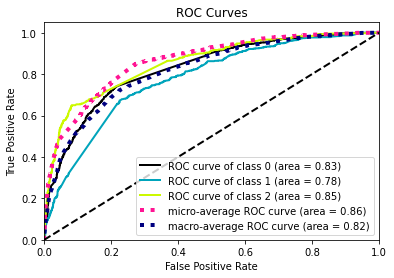

In [108]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, gradient_boosting.predict_proba(X_test))


### BaggingClassifier

In [115]:
from sklearn.ensemble import BaggingClassifier
bgc=BaggingClassifier(n_estimators=50)
bgc.fit(X_train, y_train)

print("Best Parameters:")


bgr_pred=bgc.predict(X_test)

#print confusion matrix and classification report
print(confusion_matrix(y_test,bgr_pred))

print(classification_report(y_test,bgr_pred))


Best Parameters:
[[1597  136   67]
 [ 248  300   63]
 [ 152   68  260]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1800
           1       0.60      0.49      0.54       611
           2       0.67      0.54      0.60       480

    accuracy                           0.75      2891
   macro avg       0.69      0.64      0.66      2891
weighted avg       0.73      0.75      0.74      2891



In [118]:
#store recall and f1score for class 0 i.e negative sentiment
metrics_value_bgc=precision_recall_fscore_support(y_test, bgr_pred, average=None,labels=[0,1,2])

recall_for_class_0_bgc=round(metrics_value_bgc[1][0],2)
f1score_for_class_0_bgc=round(metrics_value_bgc[2][0],2)

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


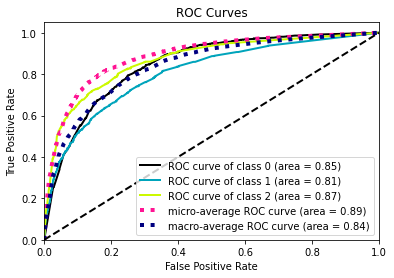

In [119]:
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, bgc.predict_proba(X_test))


### AdaBoostClassifier

In [123]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=500)

ada.fit(X_train,y_train)
ada_pred=ada.predict(X_test)
#print confusion matrix and classification report
print(confusion_matrix(y_test,ada_pred))

print(classification_report(y_test,ada_pred))


[[1489  236   75]
 [ 220  343   48]
 [ 129  101  250]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1800
           1       0.50      0.56      0.53       611
           2       0.67      0.52      0.59       480

    accuracy                           0.72      2891
   macro avg       0.66      0.64      0.65      2891
weighted avg       0.72      0.72      0.72      2891



C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


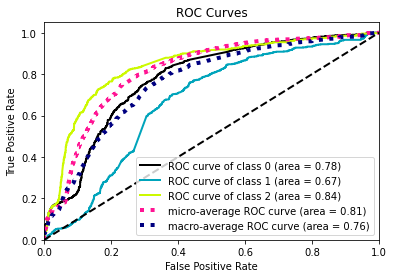

In [143]:
#store recall and f1score for class 0 i.e negative sentiment

metrics_value_ada=precision_recall_fscore_support(y_test, ada_pred, average=None,labels=[0,1,2])

recall_for_class_0_ada=round(metrics_value_ada[1][0],2)
f1score_for_class_0_ada=round(metrics_value_ada[2][0],2)
#plot roc curve
skplt.metrics.plot_roc_curve(y_test, ada.predict_proba(X_test))


### Comparison Of Model Performance

In [129]:
f1score_list=[f1score_for_class_0_logistic_regression,f1score_for_class_0_svc,f1score_for_class_0_svc,f1score_for_class_0_rf,f1score_for_class_0_dtree,f1score_for_class_0_gdb,f1score_for_class_0_bgc,f1score_for_class_0_ada]
recall_for_1_list=[recall_for_class_0_logistic_regression,recall_for_class_0_svc,recall_for_class_0_mnb,recall_for_class_0_rf,recall_for_class_0_dtree,recall_for_class_0_gdb,recall_for_class_0_bgc,recall_for_class_0_ada]
model_name_list=['Logistic Regression','SVC','Multinomial NaiveBayes','RandomForest','Decision Tree','Gradient Boosting','Bagging Classifier','Ada Boosting']
results_df=pd.DataFrame(
{
    'model_name':model_name_list,
    'f1_score':f1score_list,
    'recall_score':recall_for_1_list
    
}
)






In [130]:
results_df

,model_name,f1_score,recall_score
0,Logistic Regression,0.86,0.93
1,SVC,0.81,0.98
2,Multinomial NaiveBayes,0.81,0.94
3,RandomForest,0.77,1.00
4,Decision Tree,0.80,0.96
5,Gradient Boosting,0.80,0.97
6,Bagging Classifier,0.84,0.89
7,Ada Boosting,0.82,0.83


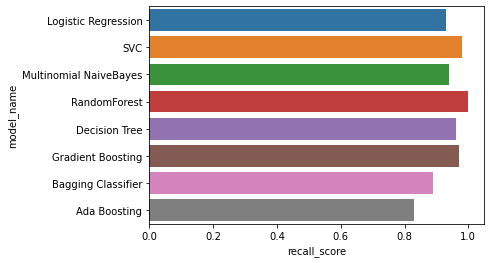

In [145]:
#plot recall
sns.barplot(data=results_df,x='recall_score',y='model_name')

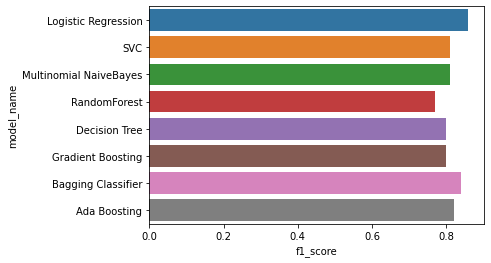

In [144]:
#plot f1_score
sns.barplot(data=results_df,x='f1_score',y='model_name')

### Conclusion

* From the above table and barplot we can see that Logistic Regression helps in better classification compared to other models.
* Logistic Regression has the proper balance between recall and f1score. Helps in better classification of negative sentiment and also performs less misclassifcation compared to other models.

* So considering the class huge imbalance, We can say Logistic Regression will be generalized model to do classification.

* Though samples related to the class of interest  are  more in number, we also need to take care of avoiding misclassifications.



* The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

* Recall — Also called Sensitivity, Probability of Detection, True Positive Rate. The ratio of correct positive predictions to the total positives examples

* AUC–ROC curve is the model selection metric for bi–multi class classification problem. ROC is a probability curve for different classes. ROC tells us how good the model is for distinguishing the given classes, in terms of the predicted probability.A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis. The bigger the area covered, the better the machine learning models is at distinguishing the given classes. Ideal value for AUC is 1.



* I tried Word embedding too, but  results were approximately same.



### Save Model

In [142]:
import pickle
filename = 'finalized_model_LR.pkl'
pickle.dump(CV_lr, open(filename, 'wb'))


### We can give a try for

* More ML models with proper hyper parameter tunning (Not able to do so because of time constraint)
* We can use Deep Learning models and check performance
* Facebook fasttext for classification
